In [ ]:
import os
import keras

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
os.chdir('/content/gdrive/My Drive/Momothesis')

Mounted at /content/gdrive


In [ ]:
scans20 = np.load('data/mitos_atypia/arrays/scans_split_x20_resized.npy')
scans20 = list(scans20)
for i, img in enumerate(scans20):
  scans20[i] = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
scans20 = np.r_[scans20]
scans20_t = scans20[20000:]
scans20 = scans20[:20000]

In [ ]:
def generate_train_test(array, train_size = 0.8):
  array = np.random.permutation(array)

  train_size = int(len(array) * 0.8)
  test_size = len(array) - train_size

  x_train = array[:train_size]
  x_test = array[train_size:]

  train_images = x_train.astype('float32') / 255
  test_images = x_test.astype('float32') / 255

  return train_images, test_images

In [ ]:
train, test = generate_train_test(scans20)
train = train.reshape(-1, 96, 96, 1)
test = test.reshape(-1, 96, 96, 1)

input = Input(shape = (96, 96, 1))

In [ ]:
train_X,valid_X,train_ground,valid_ground = train_test_split(train,
                                                             train, 
                                                             test_size=0.2)

In [ ]:
def autoencoder(input):
  #encoder
  conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

  #decoder
  conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
  up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
  conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
  up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
  
  return decoded

In [ ]:
autoencoder = Model(input, autoencoder(input))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 96, 96, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 64)        9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=128,epochs=50,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/50
100/100 [==============================] - 10s 104ms/step - loss: 0.0299 - val_loss: 0.0220
Epoch 2/50
100/100 [==============================] - 10s 105ms/step - loss: 0.0159 - val_loss: 0.0135
Epoch 3/50
100/100 [==============================] - 10s 104ms/step - loss: 0.0121 - val_loss: 0.0095
Epoch 4/50
100/100 [==============================] - 10s 103ms/step - loss: 0.0104 - val_loss: 0.0097
Epoch 5/50
100/100 [==============================] - 10s 103ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 6/50
100/100 [==============================] - 10s 102ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 7/50
100/100 [==============================] - 10s 102ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 8/50
100/100 [==============================] - 10s 103ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 9/50
100/100 [==============================] - 10s 103ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 10/50
100/100 [==============================] - 10s 103ms/step - l

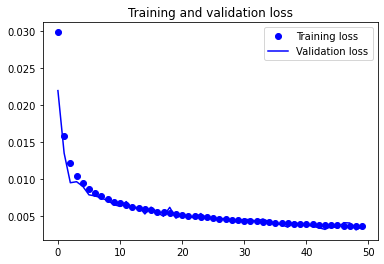

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
pred = autoencoder.predict(test)

Test


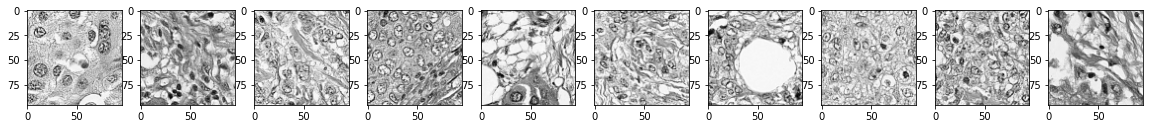

Reconstruction of Test


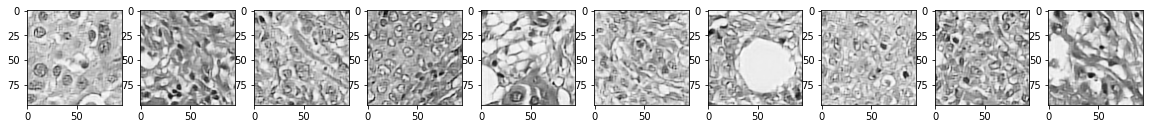

In [ ]:
plt.figure(figsize=(20, 4))
print("Test")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [ ]:
scans20_t = scans20_t.reshape(-1, 96, 96, 1)

In [ ]:
pred_test = autoencoder.predict(scans20_t[:10])

Test


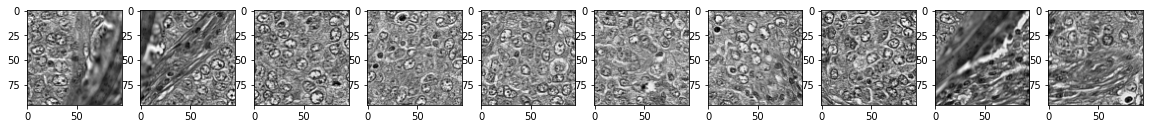

Reconstruction of Test


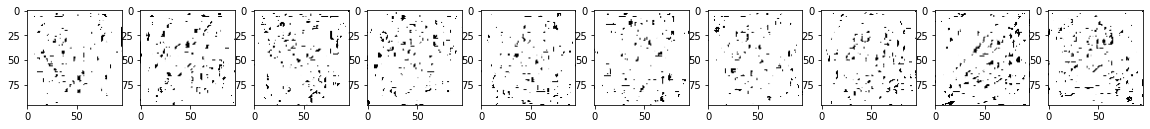

In [ ]:
plt.figure(figsize=(20, 4))
print("Test")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(scans20_t[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred_test[i, ..., 0], cmap='gray')  
plt.show()

In [ ]:
# predict
predGood = autoencoder.predict(test)
predBad = autoencoder.predict(scans20_t)
# reconstruction error
rec1 = np.sum((predGood - test)**2, axis=(1, 2, 3))
rec2 = np.sum((predBad - scans20_t)**2, axis=(1, 2, 3))

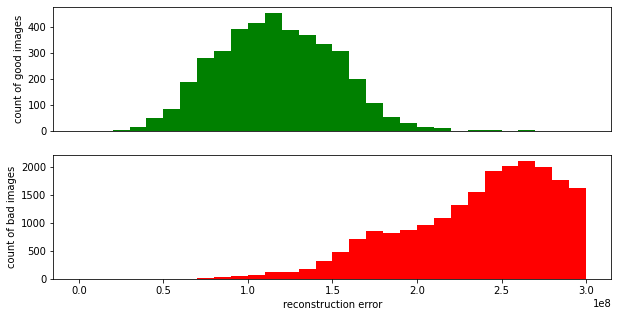

In [ ]:
# histogram
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.hist(rec1, bins=30, range=(0,300), color='g')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel("count of good images")
plt.subplot(2, 1, 2)
plt.hist(rec2, bins=30, range=(0,300000000), color='r')
plt.xlabel("reconstruction error")
plt.ylabel("count of bad images")
plt.show()